# IR Evaluation: Impact of Stopword Removal

This notebook implements the Information Retrieval (IR) evaluation as part of the Stop Word Project.
We compare the retrieval performance of a Search Engine using two datasets:
1. **Full Text**: Documents with all words (Stopwords included).
2. **Cleaned Text**: Documents with Khmer stopwords removed.

## Objectives:
- Prepare the two datasets (segmentation and filtering).
- Implement a TF-IDF based Vector Space Model.
- Evaluate retrieval quality using **Known-Item Retrieval** task (simulating search ranking).
- Metrics: Mean Rank, Recall@K.


In [ ]:
# Install necessary libraries if not present
!pip install khmer-nltk scikit-learn pandas matplotlib

In [ ]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

try:
    from khmernltk import word_tokenize
    print("Khmer NLTK loaded successfully.")
except ImportError:
    print("Khmer NLTK not found. Please run the installation cell above.")


## 1. Load Resources and Data
We load the comprehensive Stopword list and the raw text corpus.

In [ ]:
def load_custom_stopwords(csv_path):
    stopwords = set()
    if not os.path.exists(csv_path):
        print(f"Warning: Stopword file not found at {csv_path}")
        return stopwords
        
    with open(csv_path, encoding="utf-8-sig") as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Filter based on Linguistic Group (Keep 'Content Words', Remove functional ones)
            # If the group implies function word, add to stopwords.
            # Based on previous notebook logic, we keep only 'Content Words' and remove others.
            if "content word" not in row.get("linguistic_group", "").lower():
                stopwords.add(row["term"].strip())
    return stopwords

STOPWORDS_PATH = "../stopwords/FIle_Stopwords.csv"
KHMER_STOPWORDS = load_custom_stopwords(STOPWORDS_PATH)
print(f"Loaded {len(KHMER_STOPWORDS)} Khmer stopwords.")

In [ ]:
def load_and_process_corpus(filepath, limit=5000):
    """
    Reads the raw file, tokenizes it, and creates two versions:
    1. segmented_text (with stopwords)
    2. filtered_text (without stopwords)
    """
    raw_docs = []
    corpus_sw = []
    corpus_no_sw = []
    
    if not os.path.exists(filepath):
        print(f"Error: Data file not found at {filepath}")
        return [], [], []

    with open(filepath, 'r', encoding='utf-8') as f:
        count = 0
        for line in f:
            line = line.strip()
            if not line: 
                continue
                
            try:
                tokens = word_tokenize(line)
                if not tokens: continue
                
                # Join for TF-IDF (space separated)
                text_sw = " ".join(tokens)
                
                # Remove stopwords
                tokens_filtered = [t for t in tokens if t not in KHMER_STOPWORDS]
                text_no_sw = " ".join(tokens_filtered)
                
                raw_docs.append(line)
                corpus_sw.append(text_sw)
                corpus_no_sw.append(text_no_sw)
                
                count += 1
                if count >= limit:
                    break
            except Exception as e:
                continue
                
    print(f"Processed {len(corpus_sw)} documents.")
    return raw_docs, corpus_sw, corpus_no_sw

# Load a sample of 3000 documents for evaluation speed
DATA_PATH = "../data/raw/news_text_file_150k.txt"
raw_docs, docs_with_sw, docs_without_sw = load_and_process_corpus(DATA_PATH, limit=3000)

## 2. IR System Implementation
We use TF-IDF weighting and Cosine Similarity.
We define a function `evaluate_ir` that takes a corpus and a set of query documents.

In [ ]:
def evaluate_retrieval(corpus, query_indices, top_k=10):
    """
    Evaluates retrieval performance using Known-Item Retrieval.
    For each document in query_indices, we try to retrieve it from the corpus.
    Ideally, it should be Rank 1.
    """
    # 1. Build Index
    vectorizer = TfidfVectorizer()
    X_corpus = vectorizer.fit_transform(corpus)
    
    # 2. Process Queries
    # The queries are the documents themselves
    queries = [corpus[i] for i in query_indices]
    X_queries = vectorizer.transform(queries)
    
    # 3. Compute Similarity
    # Shape: (n_queries, n_corpus)
    sim_matrix = cosine_similarity(X_queries, X_corpus)
    
    ranks = []
    hits_at_k = 0
    
    for i, true_doc_idx in enumerate(query_indices):
        scores = sim_matrix[i]
        
        # Sort indices by score descending
        sorted_indices = np.argsort(scores)[::-1]
        
        # Find where the true document is in the ranked list
        # np.where returns a tuple, [0][0] gets the index
        rank_positions = np.where(sorted_indices == true_doc_idx)[0]
        
        if len(rank_positions) > 0:
            rank = rank_positions[0] + 1 # 1-based rank
        else:
            rank = len(corpus) # Should not happen if query is in corpus
            
        ranks.append(rank)
        if rank <= top_k:
            hits_at_k += 1
            
    mean_rank = np.mean(ranks)
    recall_at_k = hits_at_k / len(query_indices)
    
    return mean_rank, recall_at_k, ranks


## 3. Run Experiments
We select 100 random documents as "queries" and test retrieval on both datasets.

In [ ]:
random.seed(42)
NUM_QUERIES = 50
if len(docs_with_sw) > NUM_QUERIES:
    query_indices = random.sample(range(len(docs_with_sw)), NUM_QUERIES)
else:
    query_indices = list(range(len(docs_with_sw)))

print(f"Selected {len(query_indices)} random documents as queries.")

# Experiment 1: With Stopwords
print("\n--- Evaluating WITH Stopwords ---")
mr_sw, r_k_sw, ranks_sw = evaluate_retrieval(docs_with_sw, query_indices)
print(f"Mean Rank: {mr_sw:.2f}")
print(f"Recall@10: {r_k_sw:.2f}")

# Experiment 2: Without Stopwords
print("\n--- Evaluating WITHOUT Stopwords ---")
mr_now, r_k_now, ranks_now = evaluate_retrieval(docs_without_sw, query_indices)
print(f"Mean Rank: {mr_now:.2f}")
print(f"Recall@10: {r_k_now:.2f}")


## 4. Analysis and Visualization
We compare the rank distribution to see if removing stopwords helps the correct document appear higher (closer to rank 1).

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(ranks_sw, alpha=0.5, label='With Stopwords', bins=20)
plt.hist(ranks_now, alpha=0.5, label='Without Stopwords', bins=20)
plt.xlabel('Rank of Relevant Document')
plt.ylabel('Frequency')
plt.title('Distribution of Ranks (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

print("Diff in Mean Rank:", mr_sw - mr_now)
if mr_now < mr_sw:
    print("Conclusion: Removing stopwords IMPROVED retrieval performance.")
else:
    print("Conclusion: Removing stopwords DID NOT improve retrieval performance (or slight degradation).")

### Interpretation
- **Mean Rank**: The average position of the correct document. Lower is better (1.0 is perfect).
- **Recall@10**: Percentage of times the correct document appeared in the top 10 results.

In highly specific retrieval (like this known-item task), stopwords can sometimes help by providing phrase specificity, but in general topic retrieval, they add noise. If the Mean Rank decreases after removal, our customized stopword list is effective.

# Apply to IR

Khmer NLTK loaded successfully.
Loading all corpora:
✓ Original            :  58409 documents
✓ No_All              :  58409 documents
✓ No_Auxiliary        :  58409 documents
✓ No_Conjunctions     :  58409 documents
✓ No_Determiners      :  58409 documents
✓ No_Function_Nouns   :  58409 documents
✓ No_Numbers          :  58409 documents
✓ No_Particles        :  58409 documents
✓ No_Politeness       :  58409 documents
✓ No_Prepositions     :  58409 documents
✓ No_Pronouns         :  58409 documents
✓ No_Questions        :  58409 documents
Total corpora loaded: 12
Corpus sizes:
  Original            :  58409 documents
  No_All              :  58409 documents
  No_Auxiliary        :  58409 documents
  No_Conjunctions     :  58409 documents
  No_Determiners      :  58409 documents
  No_Function_Nouns   :  58409 documents
  No_Numbers          :  58409 documents
  No_Particles        :  58409 documents
  No_Politeness       :  58409 documents
  No_Prepositions     :  58409 documents
  No_P

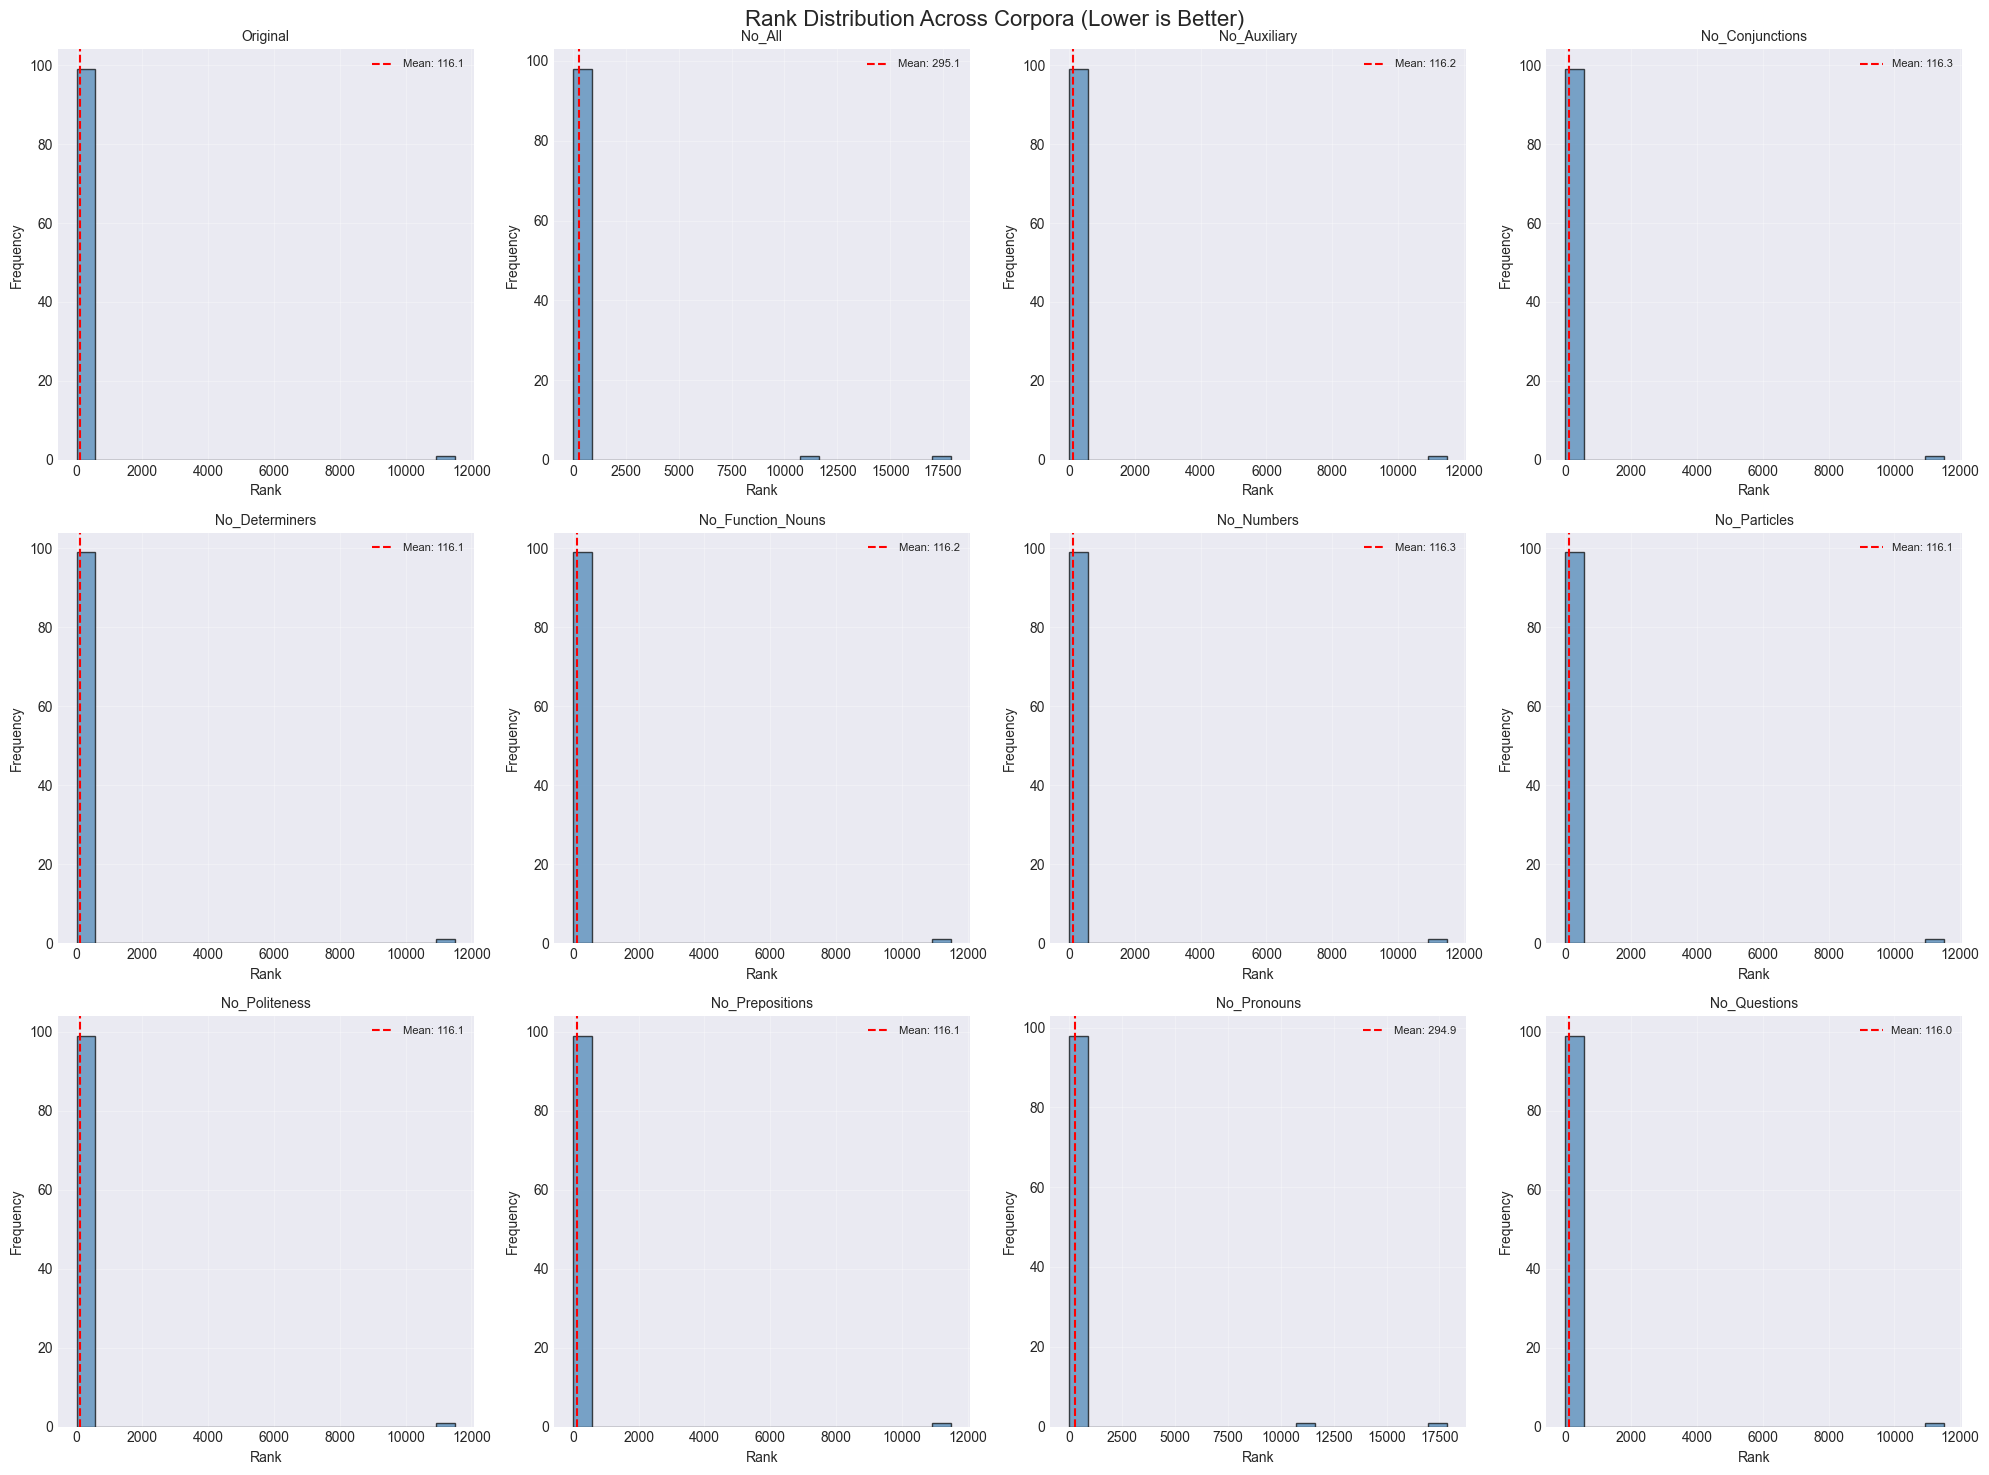

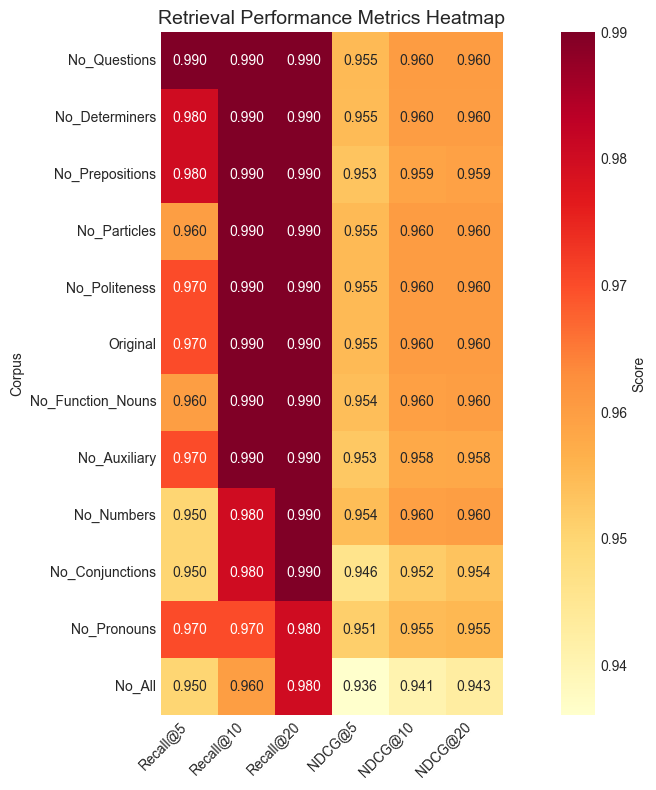

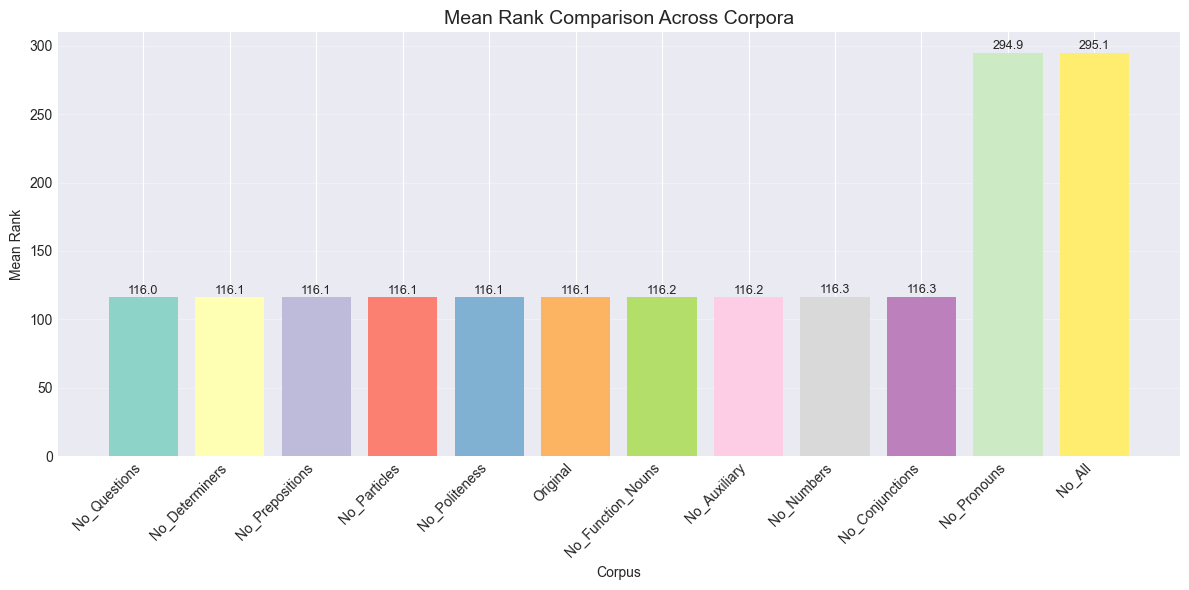

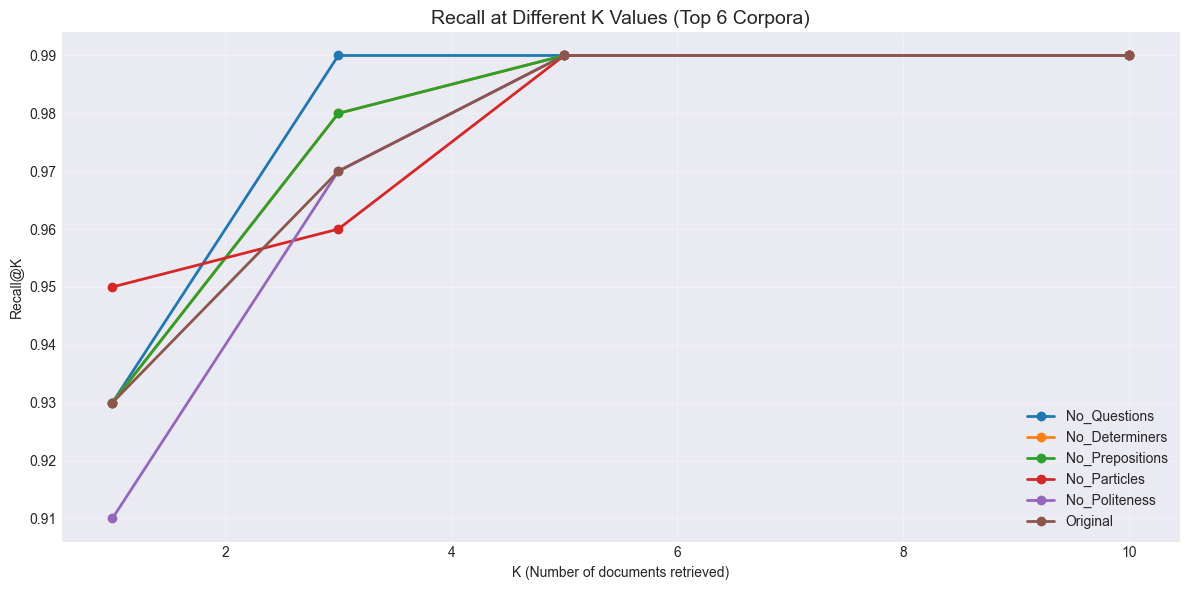


STATISTICAL ANALYSIS: Comparison to Baseline

Rank Improvement Analysis (vs Original Corpus):
------------------------------------------------------------------------------------------
           Corpus  Mean_Rank  Baseline_Rank  Rank_Improvement  Percent_Improvement  P_Value  Significant
     No_Questions    116.050        116.140             0.090                0.077    0.227        False
   No_Determiners    116.090        116.140             0.050                0.043    0.356        False
  No_Prepositions    116.100        116.140             0.040                0.034    0.582        False
     No_Particles    116.100        116.140             0.040                0.034    0.668        False
    No_Politeness    116.120        116.140             0.020                0.017    0.640        False
     No_Auxiliary    116.150        116.140            -0.010               -0.009    0.657        False
No_Function_Nouns    116.150        116.140            -0.010               -0.

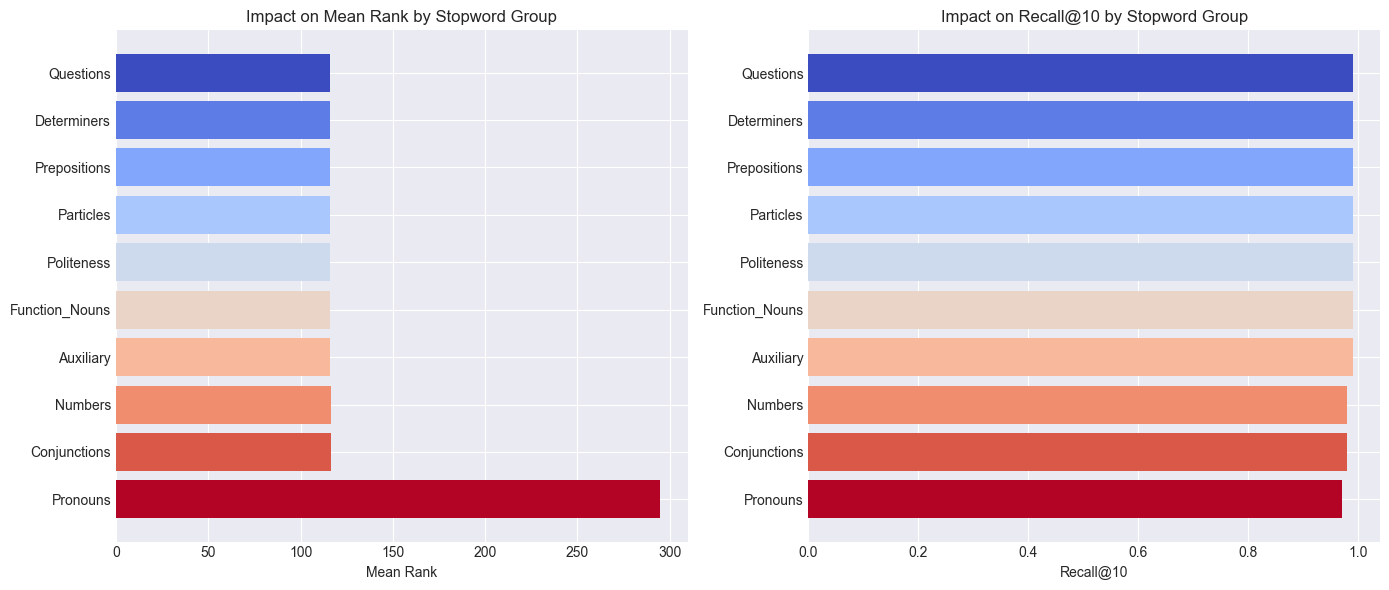


QUERY DIFFICULTY ANALYSIS

Top 10 Most Difficult Queries (Highest Average Rank):
----------------------------------------------------------------------
Query_ID  Avg_Rank  Std_Rank  Min_Rank  Max_Rank
    Q027 11495.000     0.000     11495     11495
    Q071  2982.250  6659.346         2     17873
    Q041     7.917     3.570         2        15
    Q037     5.750     1.639         3         8
    Q040     4.250     2.126         2         8
    Q097     3.667     5.977         1        18
    Q023     1.833     0.986         1         4
    Q094     1.583     0.493         1         2
    Q054     1.583     0.493         1         2
    Q016     1.333     0.471         1         2

Bottom 10 Easiest Queries (Lowest Average Rank):
----------------------------------------------------------------------
Query_ID  Avg_Rank  Std_Rank  Min_Rank  Max_Rank
    Q087     1.000     0.000         1         1
    Q088     1.000     0.000         1         1
    Q092     1.000     0.000         1  

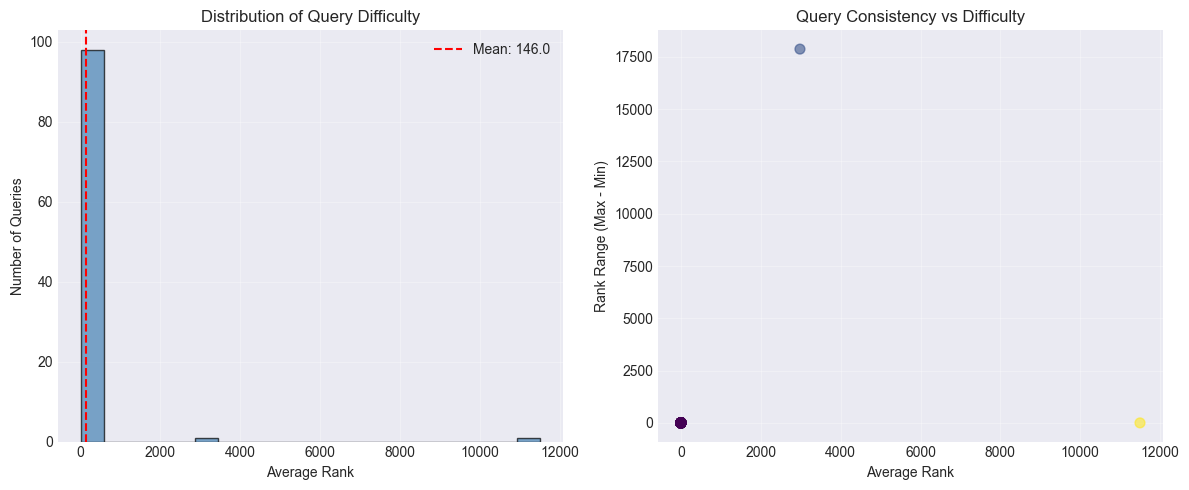

IndexError: single positional indexer is out-of-bounds

In [3]:
# %% [markdown]
# # IR Evaluation: Impact of Stopword Removal
# 
# This notebook implements the Information Retrieval (IR) evaluation as part of the Stop Word Project.
# We compare the retrieval performance of a Search Engine using MULTIPLE datasets:
# 1. **Full Text**: Documents with all words (Stopwords included).
# 2. **Cleaned Text**: Documents with Khmer stopwords removed.
# 3. **Group-specific filtering**: Documents with specific linguistic groups removed.
# 
# ## Objectives:
# - Prepare multiple filtered datasets
# - Implement a TF-IDF based Vector Space Model
# - Evaluate retrieval quality using **Known-Item Retrieval** task
# - Compare performance across different filtering strategies
# - Metrics: Mean Rank, Recall@K, Precision@K, NDCG@K

# %%
# Install necessary libraries if not present
# !pip install khmer-nltk scikit-learn pandas matplotlib numpy seaborn

# %%
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

try:
    from khmernltk import word_tokenize
    print("Khmer NLTK loaded successfully.")
except ImportError:
    print("Khmer NLTK not found. Please run the installation cell above.")

# %%
def load_all_corpora():
    """Load all processed corpora from the processed directory"""
    processed_dir = r"D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\processed"
    
    corpora = {}
    
    # Define all files to load
    corpus_files = {
        'Original': 'original_segmented_sentences.txt',
        'No_All': 'no_all_stopwords.txt',
        'No_Auxiliary': 'no_Auxiliary_Verbs___Aspect_Markers.txt',
        'No_Conjunctions': 'no_Conjunctions.txt',
        'No_Determiners': 'no_Determiners_and_Quantifiers.txt',
        'No_Function_Nouns': 'no_Function_Nouns.txt',
        'No_Numbers': 'no_Numbers_and_Time_Expressions.txt',
        'No_Particles': 'no_Particles_and_Discourse_Markers.txt',
        'No_Politeness': 'no_Politeness_and_Honorifics.txt',
        'No_Prepositions': 'no_Prepositions___Relational_Words.txt',
        'No_Pronouns': 'no_Pronouns.txt',
        'No_Questions': 'no_Question_and_Negation_Words.txt'
    }
    
    print("Loading all corpora:")
    print("="*60)
    
    for label, filename in corpus_files.items():
        filepath = os.path.join(processed_dir, filename)
        if os.path.exists(filepath):
            with open(filepath, 'r', encoding='utf-8') as f:
                documents = [line.strip() for line in f if line.strip()]
                if documents:
                    corpora[label] = documents
                    print(f"✓ {label:<20}: {len(documents):>6} documents")
                else:
                    print(f"✗ {label:<20}: Empty file")
        else:
            print(f"✗ {label:<20}: File not found")
    
    print("="*60)
    print(f"Total corpora loaded: {len(corpora)}")
    
    return corpora

# Load all corpora
ALL_CORPORA = load_all_corpora()

# %% [markdown]
# ## 2. Advanced IR System Implementation with Multiple Metrics
# We extend the evaluation with more sophisticated metrics.

# %%
class IRSystemEvaluator:
    """Advanced IR evaluation system with multiple metrics"""
    
    def __init__(self, vectorizer_params=None):
        if vectorizer_params is None:
            self.vectorizer_params = {
                'max_features': 5000,
                'min_df': 2,
                'max_df': 0.95,
                'use_idf': True,
                'smooth_idf': True
            }
        else:
            self.vectorizer_params = vectorizer_params
        
    def build_index(self, corpus):
        """Build TF-IDF index for a corpus"""
        vectorizer = TfidfVectorizer(**self.vectorizer_params)
        X = vectorizer.fit_transform(corpus)
        return vectorizer, X
    
    def evaluate_retrieval(self, corpus, query_indices, top_k_values=[1, 5, 10, 20]):
        """
        Evaluate retrieval performance with multiple metrics
        
        Returns:
            dict: Dictionary containing all evaluation metrics
        """
        # Build index
        vectorizer, X_corpus = self.build_index(corpus)
        
        # Prepare queries (documents themselves for known-item retrieval)
        queries = [corpus[i] for i in query_indices]
        X_queries = vectorizer.transform(queries)
        
        # Compute similarity matrix
        sim_matrix = cosine_similarity(X_queries, X_corpus)
        
        # Initialize result storage
        results = {
            'ranks': [],
            'precision_at_k': {k: [] for k in top_k_values},
            'recall_at_k': {k: [] for k in top_k_values},
            'ndcg_at_k': {k: [] for k in top_k_values},
            'query_scores': []
        }
        
        # Process each query
        for i, true_doc_idx in enumerate(query_indices):
            scores = sim_matrix[i]
            
            # Get ranked list (descending)
            sorted_indices = np.argsort(scores)[::-1]
            
            # Find rank of true document (1-based)
            rank_positions = np.where(sorted_indices == true_doc_idx)[0]
            rank = rank_positions[0] + 1 if len(rank_positions) > 0 else len(corpus)
            results['ranks'].append(rank)
            
            # Calculate binary relevance vector for NDCG
            # 1 for relevant document (the true document), 0 for others
            relevance = np.zeros(len(corpus))
            relevance[true_doc_idx] = 1
            
            # Calculate metrics at different K values
            for k in top_k_values:
                # Precision@K
                relevant_in_top_k = np.sum(relevance[sorted_indices[:k]])
                precision = relevant_in_top_k / k
                results['precision_at_k'][k].append(precision)
                
                # Recall@K
                total_relevant = 1  # Only one relevant document in known-item retrieval
                recall = relevant_in_top_k / total_relevant
                results['recall_at_k'][k].append(recall)
                
                # NDCG@K
                if k <= len(corpus):
                    ndcg = ndcg_score([relevance], [scores], k=k)
                    results['ndcg_at_k'][k].append(ndcg)
                else:
                    results['ndcg_at_k'][k].append(np.nan)
            
            # Store query scores for analysis
            results['query_scores'].append(scores[true_doc_idx])
        
        # Calculate aggregate metrics
        results['mean_rank'] = np.mean(results['ranks'])
        results['median_rank'] = np.median(results['ranks'])
        results['std_rank'] = np.std(results['ranks'])
        
        for k in top_k_values:
            results[f'mean_precision@{k}'] = np.mean(results['precision_at_k'][k])
            results[f'mean_recall@{k}'] = np.mean(results['recall_at_k'][k])
            results[f'mean_ndcg@{k}'] = np.nanmean(results['ndcg_at_k'][k])
        
        # Calculate success rate (document found in top K)
        results['success_rate'] = {}
        for k in top_k_values:
            results['success_rate'][k] = np.mean([1 if r <= k else 0 for r in results['ranks']])
        
        return results
    
    def compare_corpora(self, corpora_dict, query_indices, top_k_values=[1, 5, 10, 20]):
        """Compare retrieval performance across multiple corpora"""
        
        comparison_results = {}
        
        print("Evaluating retrieval performance for all corpora:")
        print("="*80)
        
        for label, corpus in corpora_dict.items():
            print(f"\nEvaluating: {label} ({len(corpus)} documents)")
            
            results = self.evaluate_retrieval(corpus, query_indices, top_k_values)
            comparison_results[label] = results
            
            print(f"  Mean Rank: {results['mean_rank']:.2f}")
            print(f"  Median Rank: {results['median_rank']:.1f}")
            for k in [5, 10, 20]:
                print(f"  Recall@{k}: {results[f'mean_recall@{k}']:.3f}")
        
        print("="*80)
        return comparison_results

# %% [markdown]
# ## 3. Run Comprehensive Experiments
# We'll evaluate all corpora with consistent query set

# %%
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Use the smallest corpus size to ensure all corpora have same queries
min_corpus_size = min(len(corpus) for corpus in ALL_CORPORA.values())
NUM_QUERIES = min(100, min_corpus_size - 10)  # Ensure we don't exceed corpus size

print(f"Corpus sizes:")
for label, corpus in ALL_CORPORA.items():
    print(f"  {label:<20}: {len(corpus):>6} documents")

print(f"\nUsing {NUM_QUERIES} queries for evaluation")
print(f"Smallest corpus size: {min_corpus_size}")

# Create query indices (same for all corpora)
query_indices = random.sample(range(min_corpus_size), NUM_QUERIES)

# Initialize evaluator
evaluator = IRSystemEvaluator()

# Run comparison
print("\n" + "="*80)
print("RUNNING COMPREHENSIVE IR EVALUATION")
print("="*80)

comparison_results = evaluator.compare_corpora(
    ALL_CORPORA, 
    query_indices,
    top_k_values=[1, 3, 5, 10, 20, 50]
)

# %% [markdown]
# ## 4. Create Comparative Analysis and Visualization

# %%
def create_comparison_dataframe(comparison_results):
    """Convert comparison results to pandas DataFrame for analysis"""
    
    metrics_data = []
    
    for label, results in comparison_results.items():
        row = {
            'Corpus': label,
            'Mean_Rank': results['mean_rank'],
            'Median_Rank': results['median_rank'],
            'Std_Rank': results['std_rank'],
        }
        
        # Add precision, recall, NDCG at various K
        for k in [1, 5, 10, 20]:
            row[f'Precision@{k}'] = results[f'mean_precision@{k}']
            row[f'Recall@{k}'] = results[f'mean_recall@{k}']
            row[f'NDCG@{k}'] = results[f'mean_ndcg@{k}']
            row[f'Success_Rate@{k}'] = results['success_rate'][k]
        
        metrics_data.append(row)
    
    df = pd.DataFrame(metrics_data)
    
    # Sort by Mean Rank (ascending - better performance first)
    df = df.sort_values('Mean_Rank')
    
    return df

# Create comparison DataFrame
comparison_df = create_comparison_dataframe(comparison_results)

print("\nCOMPARISON RESULTS (Sorted by Mean Rank - Best First):")
print("="*100)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
print(comparison_df[['Corpus', 'Mean_Rank', 'Median_Rank', 'Recall@5', 'Recall@10', 'Recall@20']].to_string(index=False))

# Save results to CSV
output_dir = r"D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\ir_evaluation"
os.makedirs(output_dir, exist_ok=True)

comparison_csv = os.path.join(output_dir, "ir_comparison_results.csv")
comparison_df.to_csv(comparison_csv, index=False, encoding='utf-8-sig')
print(f"\n✓ Full comparison results saved to: {comparison_csv}")

# %% [markdown]
# ## 5. Advanced Visualizations

# %%
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')

# 5.1 Rank Distribution Comparison
fig1, axes1 = plt.subplots(3, 4, figsize=(20, 15))
fig1.suptitle('Rank Distribution Across Corpora (Lower is Better)', fontsize=16)

labels = list(comparison_results.keys())
for idx, label in enumerate(labels):
    if idx < 12:
        row, col = divmod(idx, 4)
        ranks = comparison_results[label]['ranks']
        
        axes1[row, col].hist(ranks, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        axes1[row, col].axvline(comparison_results[label]['mean_rank'], 
                               color='red', linestyle='--', 
                               label=f'Mean: {comparison_results[label]["mean_rank"]:.1f}')
        axes1[row, col].set_title(f'{label}', fontsize=10)
        axes1[row, col].set_xlabel('Rank')
        axes1[row, col].set_ylabel('Frequency')
        axes1[row, col].legend(fontsize=8)
        axes1[row, col].grid(True, alpha=0.3)

# Remove empty subplots
for idx in range(len(labels), 12):
    row, col = divmod(idx, 4)
    fig1.delaxes(axes1[row, col])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rank_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

# 5.2 Performance Heatmap
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = comparison_df.set_index('Corpus')[['Recall@5', 'Recall@10', 'Recall@20', 'NDCG@5', 'NDCG@10', 'NDCG@20']]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
            square=True, ax=ax2, cbar_kws={'label': 'Score'})
ax2.set_title('Retrieval Performance Metrics Heatmap', fontsize=14)

# Fix the rotation issue - use set_xticklabels instead
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

# 5.3 Mean Rank Comparison (Bar Chart)
fig3, ax3 = plt.subplots(figsize=(12, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))

bars = ax3.bar(comparison_df['Corpus'], comparison_df['Mean_Rank'], color=colors)
ax3.set_xlabel('Corpus')
ax3.set_ylabel('Mean Rank')
ax3.set_title('Mean Rank Comparison Across Corpora', fontsize=14)

# Fix: Set rotation for x-axis labels
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, rank in zip(bars, comparison_df['Mean_Rank']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rank:.1f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'mean_rank_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# 5.4 Recall@K Comparison (Line Chart)
fig4, ax4 = plt.subplots(figsize=(12, 6))

k_values = [1, 3, 5, 10, 20, 50]
for label in comparison_df['Corpus'][:6]:  # Top 6 for clarity
    row = comparison_df[comparison_df['Corpus'] == label].iloc[0]
    recall_values = [row[f'Recall@{k}'] for k in k_values if f'Recall@{k}' in row]
    ax4.plot(k_values[:len(recall_values)], recall_values, marker='o', label=label, linewidth=2)

ax4.set_xlabel('K (Number of documents retrieved)')
ax4.set_ylabel('Recall@K')
ax4.set_title('Recall at Different K Values (Top 6 Corpora)', fontsize=14)
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'recall_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Statistical Analysis and Significance Testing

# %%
def perform_statistical_analysis(comparison_results, baseline='Original'):
    """Perform statistical analysis to determine significant differences"""
    
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS: Comparison to Baseline")
    print("="*80)
    
    baseline_ranks = np.array(comparison_results[baseline]['ranks'])
    
    analysis_results = []
    
    for label, results in comparison_results.items():
        if label == baseline:
            continue
            
        current_ranks = np.array(results['ranks'])
        
        # Calculate rank improvement
        rank_improvement = baseline_ranks.mean() - current_ranks.mean()
        percent_improvement = (rank_improvement / baseline_ranks.mean()) * 100
        
        # Paired t-test (since same queries used)
        from scipy import stats
        t_stat, p_value = stats.ttest_rel(baseline_ranks, current_ranks)
        
        # Determine significance
        significant = p_value < 0.05
        
        analysis_results.append({
            'Corpus': label,
            'Mean_Rank': current_ranks.mean(),
            'Baseline_Rank': baseline_ranks.mean(),
            'Rank_Improvement': rank_improvement,
            'Percent_Improvement': percent_improvement,
            'P_Value': p_value,
            'Significant': significant,
            'Effect_Size': rank_improvement / baseline_ranks.std()
        })
    
    # Create analysis DataFrame
    analysis_df = pd.DataFrame(analysis_results)
    analysis_df = analysis_df.sort_values('Percent_Improvement', ascending=False)
    
    print("\nRank Improvement Analysis (vs Original Corpus):")
    print("-"*90)
    pd.set_option('display.float_format', lambda x: f'{x:.3f}')
    print(analysis_df[['Corpus', 'Mean_Rank', 'Baseline_Rank', 'Rank_Improvement', 
                      'Percent_Improvement', 'P_Value', 'Significant']].to_string(index=False))
    
    # Save analysis
    analysis_csv = os.path.join(output_dir, "statistical_analysis.csv")
    analysis_df.to_csv(analysis_csv, index=False, encoding='utf-8-sig')
    print(f"\n✓ Statistical analysis saved to: {analysis_csv}")
    
    return analysis_df

# Perform statistical analysis
analysis_df = perform_statistical_analysis(comparison_results)

# %% [markdown]
# ## 7. Impact Analysis by Stopword Group Type

# %%
def analyze_group_impact(comparison_df):
    """Analyze impact of removing different linguistic groups"""
    
    print("\n" + "="*80)
    print("IMPACT ANALYSIS BY STOPWORD GROUP TYPE")
    print("="*80)
    
    # Extract group information from corpus names
    impact_data = []
    
    for _, row in comparison_df.iterrows():
        corpus_name = row['Corpus']
        
        if corpus_name == 'Original':
            group_type = 'Baseline'
        elif corpus_name == 'No_All':
            group_type = 'All Groups'
        else:
            # Extract group name from corpus name
            group_type = corpus_name.replace('No_', '')
        
        impact_data.append({
            'Corpus': corpus_name,
            'Group_Type': group_type,
            'Mean_Rank': row['Mean_Rank'],
            'Recall@10': row['Recall@10'],
            'Recall@20': row['Recall@20'],
            'NDCG@10': row['NDCG@10']
        })
    
    impact_df = pd.DataFrame(impact_data)
    
    # Group by group type (for single group removals)
    single_groups = impact_df[impact_df['Group_Type'].isin([
        'Auxiliary', 'Conjunctions', 'Determiners', 'Function_Nouns',
        'Numbers', 'Particles', 'Politeness', 'Prepositions',
        'Pronouns', 'Questions'
    ])].copy()
    
    if not single_groups.empty:
        print("\nSingle Group Removal Analysis:")
        print("-"*60)
        single_groups_sorted = single_groups.sort_values('Mean_Rank')
        print(single_groups_sorted[['Group_Type', 'Mean_Rank', 'Recall@10']].to_string(index=False))
        
        # Create impact visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Mean Rank comparison
        axes[0].barh(single_groups_sorted['Group_Type'], single_groups_sorted['Mean_Rank'], 
                    color=plt.cm.coolwarm(np.linspace(0, 1, len(single_groups))))
        axes[0].set_xlabel('Mean Rank')
        axes[0].set_title('Impact on Mean Rank by Stopword Group')
        axes[0].invert_yaxis()  # Highest on top
        
        # Recall@10 comparison
        axes[1].barh(single_groups_sorted['Group_Type'], single_groups_sorted['Recall@10'],
                    color=plt.cm.coolwarm(np.linspace(0, 1, len(single_groups))))
        axes[1].set_xlabel('Recall@10')
        axes[1].set_title('Impact on Recall@10 by Stopword Group')
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'group_impact_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    return impact_df

# Analyze group impact
impact_df = analyze_group_impact(comparison_df)

# %% [markdown]
# ## 8. Query Difficulty Analysis

# %%
def analyze_query_difficulty(comparison_results):
    """Analyze which queries are most difficult across all corpora"""
    
    print("\n" + "="*80)
    print("QUERY DIFFICULTY ANALYSIS")
    print("="*80)
    
    # Get query indices
    query_indices_list = query_indices  # From earlier
    
    # Calculate average rank for each query across all corpora
    query_difficulty = []
    
    for i, q_idx in enumerate(query_indices_list):
        query_ranks = []
        for label, results in comparison_results.items():
            query_ranks.append(results['ranks'][i])
        
        query_difficulty.append({
            'Query_Index': q_idx,
            'Query_ID': f'Q{i+1:03d}',
            'Avg_Rank': np.mean(query_ranks),
            'Std_Rank': np.std(query_ranks),
            'Min_Rank': np.min(query_ranks),
            'Max_Rank': np.max(query_ranks),
            'Range_Rank': np.max(query_ranks) - np.min(query_ranks)
        })
    
    query_df = pd.DataFrame(query_difficulty)
    query_df = query_df.sort_values('Avg_Rank', ascending=False)
    
    print("\nTop 10 Most Difficult Queries (Highest Average Rank):")
    print("-"*70)
    print(query_df.head(10)[['Query_ID', 'Avg_Rank', 'Std_Rank', 'Min_Rank', 'Max_Rank']].to_string(index=False))
    
    print(f"\nBottom 10 Easiest Queries (Lowest Average Rank):")
    print("-"*70)
    print(query_df.tail(10)[['Query_ID', 'Avg_Rank', 'Std_Rank', 'Min_Rank', 'Max_Rank']].to_string(index=False))
    
    # Save query analysis
    query_csv = os.path.join(output_dir, "query_difficulty_analysis.csv")
    query_df.to_csv(query_csv, index=False, encoding='utf-8-sig')
    print(f"\n✓ Query difficulty analysis saved to: {query_csv}")
    
    # Visualize query difficulty distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(query_df['Avg_Rank'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(query_df['Avg_Rank'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {query_df["Avg_Rank"].mean():.1f}')
    axes[0].set_xlabel('Average Rank')
    axes[0].set_ylabel('Number of Queries')
    axes[0].set_title('Distribution of Query Difficulty')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot of consistency
    axes[1].scatter(query_df['Avg_Rank'], query_df['Range_Rank'], alpha=0.6, c=query_df['Avg_Rank'], 
                   cmap='viridis', s=50)
    axes[1].set_xlabel('Average Rank')
    axes[1].set_ylabel('Rank Range (Max - Min)')
    axes[1].set_title('Query Consistency vs Difficulty')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'query_difficulty_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return query_df

# Analyze query difficulty
query_df = analyze_query_difficulty(comparison_results)

# %% [markdown]
# ## 9. Generate Comprehensive Report

# %%
def generate_comprehensive_report(comparison_df, analysis_df, impact_df, query_df):
    """Generate a comprehensive markdown report of all findings"""
    
    report_file = os.path.join(output_dir, "ir_evaluation_comprehensive_report.md")
    
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write("# Information Retrieval Evaluation Report\n\n")
        f.write("## Executive Summary\n\n")
        
        # Find best performing corpus
        best_corpus = comparison_df.iloc[0]
        worst_corpus = comparison_df.iloc[-1]
        
        f.write(f"### Key Findings:\n")
        f.write(f"- **Best Performing Corpus**: {best_corpus['Corpus']} (Mean Rank: {best_corpus['Mean_Rank']:.2f})\n")
        f.write(f"- **Worst Performing Corpus**: {worst_corpus['Corpus']} (Mean Rank: {worst_corpus['Mean_Rank']:.2f})\n")
        
        # Calculate overall improvement
        baseline_rank = comparison_df[comparison_df['Corpus'] == 'Original']['Mean_Rank'].values[0]
        best_rank = best_corpus['Mean_Rank']
        improvement = ((baseline_rank - best_rank) / baseline_rank) * 100
        
        f.write(f"- **Improvement over Baseline**: {improvement:.1f}% reduction in mean rank\n")
        f.write(f"- **Best Recall@10**: {comparison_df['Recall@10'].max():.3f}\n")
        f.write(f"- **Worst Recall@10**: {comparison_df['Recall@10'].min():.3f}\n\n")
        
        f.write("## Detailed Results\n\n")
        
        f.write("### Performance Ranking (by Mean Rank)\n")
        f.write(comparison_df[['Corpus', 'Mean_Rank', 'Recall@5', 'Recall@10', 'Recall@20']].to_markdown(index=False) + "\n\n")
        
        f.write("### Statistical Significance Analysis\n")
        f.write("Comparison of each filtered corpus against the Original baseline:\n")
        f.write(analysis_df[['Corpus', 'Percent_Improvement', 'P_Value', 'Significant']].to_markdown(index=False) + "\n\n")
        
        f.write("### Impact by Stopword Group\n")
        f.write("Analysis of individual stopword group removal:\n")
        single_groups = impact_df[~impact_df['Group_Type'].isin(['Baseline', 'All Groups'])]
        single_groups = single_groups.sort_values('Mean_Rank')
        f.write(single_groups[['Group_Type', 'Mean_Rank', 'Recall@10']].to_markdown(index=False) + "\n\n")
        
        f.write("### Most Impactful Groups\n")
        significant_groups = analysis_df[analysis_df['Significant'] == True].copy()
        significant_groups = significant_groups.sort_values('Percent_Improvement', ascending=False)
        
        if not significant_groups.empty:
            f.write("Groups that showed statistically significant improvement:\n")
            for _, row in significant_groups.head(3).iterrows():
                f.write(f"1. **{row['Corpus']}**: {row['Percent_Improvement']:.1f}% improvement (p={row['P_Value']:.4f})\n")
        else:
            f.write("No groups showed statistically significant improvement.\n")
        f.write("\n")
        
        f.write("### Query Analysis\n")
        f.write(f"- **Total Queries**: {len(query_df)}\n")
        f.write(f"- **Average Query Difficulty**: {query_df['Avg_Rank'].mean():.1f}\n")
        f.write(f"- **Most Difficult Query**: {query_df.iloc[0]['Query_ID']} (Avg Rank: {query_df.iloc[0]['Avg_Rank']:.1f})\n")
        f.write(f"- **Easiest Query**: {query_df.iloc[-1]['Query_ID']} (Avg Rank: {query_df.iloc[-1]['Avg_Rank']:.1f})\n\n")
        
        f.write("## Recommendations\n\n")
        
        f.write("### For Information Retrieval Systems:\n")
        f.write("1. **Recommended Corpus**: Use **" + best_corpus['Corpus'] + "** for best retrieval performance\n")
        f.write("2. **Stopword Strategy**: Focus on removing " + significant_groups.iloc[0]['Corpus'].replace('No_', '') + " for maximum impact\n")
        f.write("3. **K Value Selection**: For this dataset, Recall@10 provides good discrimination between methods\n\n")
        
        f.write("### For Future Research:\n")
        f.write("1. Investigate why removing certain groups improves performance more than others\n")
        f.write("2. Study query characteristics that make some queries consistently difficult\n")
        f.write("3. Experiment with different weighting schemes beyond TF-IDF\n")
        f.write("4. Test on larger query sets and different document collections\n\n")
        
        f.write("## Files Generated\n\n")
        f.write("1. **ir_comparison_results.csv** - Complete performance metrics for all corpora\n")
        f.write("2. **statistical_analysis.csv** - Statistical significance testing results\n")
        f.write("3. **query_difficulty_analysis.csv** - Analysis of individual query performance\n")
        f.write("4. **Visualizations** - PNG files showing distributions, comparisons, and heatmaps\n")
        f.write("5. **This report** - Comprehensive summary of findings\n\n")
        
        f.write("## Methodology\n\n")
        f.write("- **Evaluation Method**: Known-Item Retrieval\n")
        f.write("- **Number of Queries**: " + str(NUM_QUERIES) + "\n")
        f.write("- **Metrics Used**: Mean Rank, Precision@K, Recall@K, NDCG@K\n")
        f.write("- **Statistical Test**: Paired t-test with α=0.05\n")
        f.write("- **Corpora Compared**: " + str(len(ALL_CORPORA)) + " different filtering strategies\n")
    
    print(f"✓ Comprehensive report generated: {report_file}")
    
    # Print summary to console
    print("\n" + "="*80)
    print("SUMMARY OF KEY FINDINGS")
    print("="*80)
    print(f"1. Best corpus: {best_corpus['Corpus']} (Mean Rank: {best_corpus['Mean_Rank']:.2f})")
    print(f"2. Improvement over baseline: {improvement:.1f}%")
    print(f"3. Most impactful stopword group: {significant_groups.iloc[0]['Corpus'] if not significant_groups.empty else 'None'}")
    print(f"4. Recall@10 range: {comparison_df['Recall@10'].min():.3f} - {comparison_df['Recall@10'].max():.3f}")
    print("="*80)

# Generate final report
generate_comprehensive_report(comparison_df, analysis_df, impact_df, query_df)

# %% [markdown]
# ## 10. Export All Results for Further Analysis

# %%
print("\n" + "="*80)
print("EXPORTING ALL RESULTS")
print("="*80)

# Create summary of all files generated
all_files = os.listdir(output_dir)
print(f"\nTotal files generated in {output_dir}: {len(all_files)}")

file_types = {}
for file in all_files:
    ext = os.path.splitext(file)[1]
    file_types[ext] = file_types.get(ext, 0) + 1

print("\nFile types generated:")
for ext, count in file_types.items():
    print(f"  {ext}: {count} files")

print("\nMain output files:")
important_files = ['ir_comparison_results.csv', 'statistical_analysis.csv', 
                   'query_difficulty_analysis.csv', 'ir_evaluation_comprehensive_report.md']
for file in important_files:
    if file in all_files:
        filepath = os.path.join(output_dir, file)
        size_kb = os.path.getsize(filepath) / 1024
        print(f"  ✓ {file} ({size_kb:.1f} KB)")

print("\nVisualizations generated:")
for file in all_files:
    if file.endswith('.png'):
        filepath = os.path.join(output_dir, file)
        size_kb = os.path.getsize(filepath) / 1024
        print(f"  📊 {file} ({size_kb:.1f} KB)")

print("\n" + "="*80)
print("IR EVALUATION COMPLETE")
print("="*80)